# Лабораторная работа по НЛП

## TF-IDF преобразование 10 песен

### Импорты используемых библиотек

In [1]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 

nltk.download(['stopwords', 'punkt', 'wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Функция по выгрузки текста песен из сайта lyrics.com

In [3]:
def get_linkin_park_song_lyrics(max_number_songs=10):
    url = 'https://www.lyrics.com'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.5845.2271 Safari/537.36'}
    response = requests.get(f'{url}/artist/Linkin-Park/447095', headers=headers)
    soup = BeautifulSoup(response.content)
    songs = {}
    songs_extracted = 0
    for table_tag in soup.find_all('table', class_='tdata'):
        for row in table_tag.tbody.find_all('tr'):
            name = row.a.text
            if name not in songs:
                try:
                    href = row.a['href']
                    song_url = f'{url}{href}'
                    song_response = requests.get(song_url, headers=headers)
                    song_soup = BeautifulSoup(song_response.content)
                    songs[name] = song_soup.find('pre', class_='lyric-body').text
                    songs_extracted += 1
                    if songs_extracted == max_number_songs:
                        return songs
                except Exception:
                    pass

### Загрузка и предобработка данных

In [4]:
songs = get_linkin_park_song_lyrics()
songs_list = [(key, value) for key, value in songs.items()]
df = pd.DataFrame(songs_list, columns=['name', 'text'])
en_stopwords = set(stopwords.words('english'))
df

In [5]:
def preprocessing(text, stopwords):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(text.lower().split())
    text_tokens = tokenizer.tokenize(text)
    cleared_tokens = []
    for token in text_tokens:
        if token not in stopwords:
            cleared_tokens.append(lemmatizer.lemmatize(token))
    return ' '.join(cleared_tokens)

df['preprocessing'] = df.text.apply(lambda x: preprocessing(x, en_stopwords))

### Преобразование данных методом TF-IDF

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessing'])
# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['even', 'end', 'tried', 'hard', 'matter', 'far', 'thing', 'time', 'watch', 'one', 'know', 'got', 'lose', 'fall', 'go', 'though', 'rhyme', 'meant', 'kept', 'keep', 'fell', 'eventually', 'designed', 'try', 'pushed', 'memory', 'apart', 'trust', 'mind', 'put', 'inside', 'everything', 'way', 'window', 'wasted', 'valuable', 'unreal', 'tick', 'swing', 'surprised', 'start', 'spite', 'remind', 'remembering', 'recognize', 'property', 'pendulum', 'mocking', 'knew', 'fought', 'fly', 'explain', 'due', 'count', 'come', 'clock', 'acting', 'back', 'part', 'hold', 'day', 'trying', 'look', 'life', 'anymore', 'right', 'like', 'away', 'x2', 'wrong', 'wound', 'would', 'worst', 'worse', 'word', 'wondering', 'wonder', 'within', 'whirlwind', 'well', 'wave', 'watching', 'wasting', 'waste', 'wanted', 'want', 'wanna', 'walking', 'voice', 'vacancy', 'uptight', 'undertow', 'understand', 'underneath', 'unconfident', 'turning', 'turn', 'truth', 'trusted', 'true', 'top', 'today', 'tiring', 'tired', '

Полученные вектора для каждого токена исходного датасета

In [7]:
tfidf_matrix.todense()[2]

matrix([[0.        , 0.        , 0.02654262, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.02654262, 0.02256366,
         0.07962787, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.05308525, 0.        , 0.        ,
         0.30634748, 0.        , 0.        , 0.02654262, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.02256366, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.02654262, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.02654262, 0.        , 0.        , 0.        ,
         0.        , 0.07962787, 0.        , 0.        , 0.04512731,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

## Классификатор текста на основе модели BERT

### Импорт используемых библиотек

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

from transformers import BertTokenizer, BertModel

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
dataset_filename = 'IMDB_Dataset.csv'
device

device(type='cuda', index=0)

### Загрузка и обработка данных

In [2]:
df = pd.read_csv(f"data/{dataset_filename}")
sentiment_int = {'positive' : 0, 'negative': 1}
df['sentiment_int'] = df.sentiment.map(sentiment_int)
df.head()

,review,sentiment,sentiment_int
0,One of the other reviewers has mentioned that ...,positive,0
1,A wonderful little production. <br /><br />The...,positive,0
2,I thought this was a wonderful way to spend ti...,positive,0
3,Basically there's a family where a little boy ...,negative,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0


Делим данные на тренировочную, валидационную и тестовую выборки

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((40000, 3), (5000, 3), (5000, 3))

Выделяем данные по которым будем обучать данные

In [4]:
X, y = df.review, df.sentiment_int
X_train = df_train.review.to_numpy()
X_val = df_val.review.to_numpy()
y_train = df_train.sentiment_int.to_numpy()
y_val = df_val.sentiment_int.to_numpy()
X_test = df_test.review.to_numpy()
y_test = df_test.sentiment_int.to_numpy()

Создаем функцию, которая очищает текст рецензии от ссылок, html-тэгов, гиперссылок и тд

In [5]:
def text_preprocessing(temp):
    # Remove trailing whitespace
    temp = re.sub("@\S+", " ", temp)
    temp = re.sub("https*\S+", " ", temp)
    temp = re.sub("#\S+", " ", temp)
    temp = re.sub("\'\w+", '', temp)
    temp = re.sub(r'\w*\d+\w*', '', temp)
    temp = re.sub('\s{2,}', " ", temp)
    temp = re.sub(r'<.*?>', '', temp).strip()

    return temp

In [6]:
# Print sentence 0
print('Original: ', df.review.iloc[0])
print()
print('Processed: ', text_preprocessing(df.review.iloc[0]))

Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

Создадим функцию преобразования текста в тензоры, необходимые для обучения BERT'а (Ограничимся первыми 128 токенами из-за ограничений BERT'a и памяти видеокарты)

In [11]:
# Specify `MAX_LEN`
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,                   # Pad sentence to max length
            truncation=True,
            # return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Посмотрим как выглядит выход функции препроцессинга токенайзера BERT'a и преобразуем весь тренировочный и валидационный датасеты в нужный формат

In [10]:

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

E:\projects\innopolis_ai\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

Создадим DataLoader'ы для обучения модели по батчам

In [11]:

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Создание классификатора на основе модели BERT

In [18]:

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### Подготовка шагов обучения: инициализация модели, обучение и валидация

In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [24]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Запуск обучения

In [25]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.693587   |     -      |     -     |   23.47  
   1    |   40    |   0.639569   |     -      |     -     |   15.32  
   1    |   60    |   0.474205   |     -      |     -     |   15.36  
   1    |   80    |   0.377885   |     -      |     -     |   15.40  
   1    |   100   |   0.471322   |     -      |     -     |   15.44  
   1    |   120   |   0.454397   |     -      |     -     |   15.42  
   1    |   140   |   0.422884   |     -      |     -     |   15.42  
   1    |   160   |   0.542972   |     -      |     -     |   15.40  
   1    |   180   |   0.417371   |     -      |     -     |   15.48  
   1    |   200   |   0.392278   |     -      |     -     |   15.47  
   1    |   220   |   0.491655   |     -      |     -     |   15.45  
   1    |   240   |   0.467871   |     -      |     -     |   15.70  


### Оценка модели

По этапам валидационной проверки, данная модель показывает результаты по метрике accuracy - 89.9, довольно неплохой результат.
Создадим функцию для получения вероятностей предсказания для построения ROC-AUC

In [16]:

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

Функция для построения и расчета ROC-AUC

In [25]:

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9646
Accuracy: 89.88%


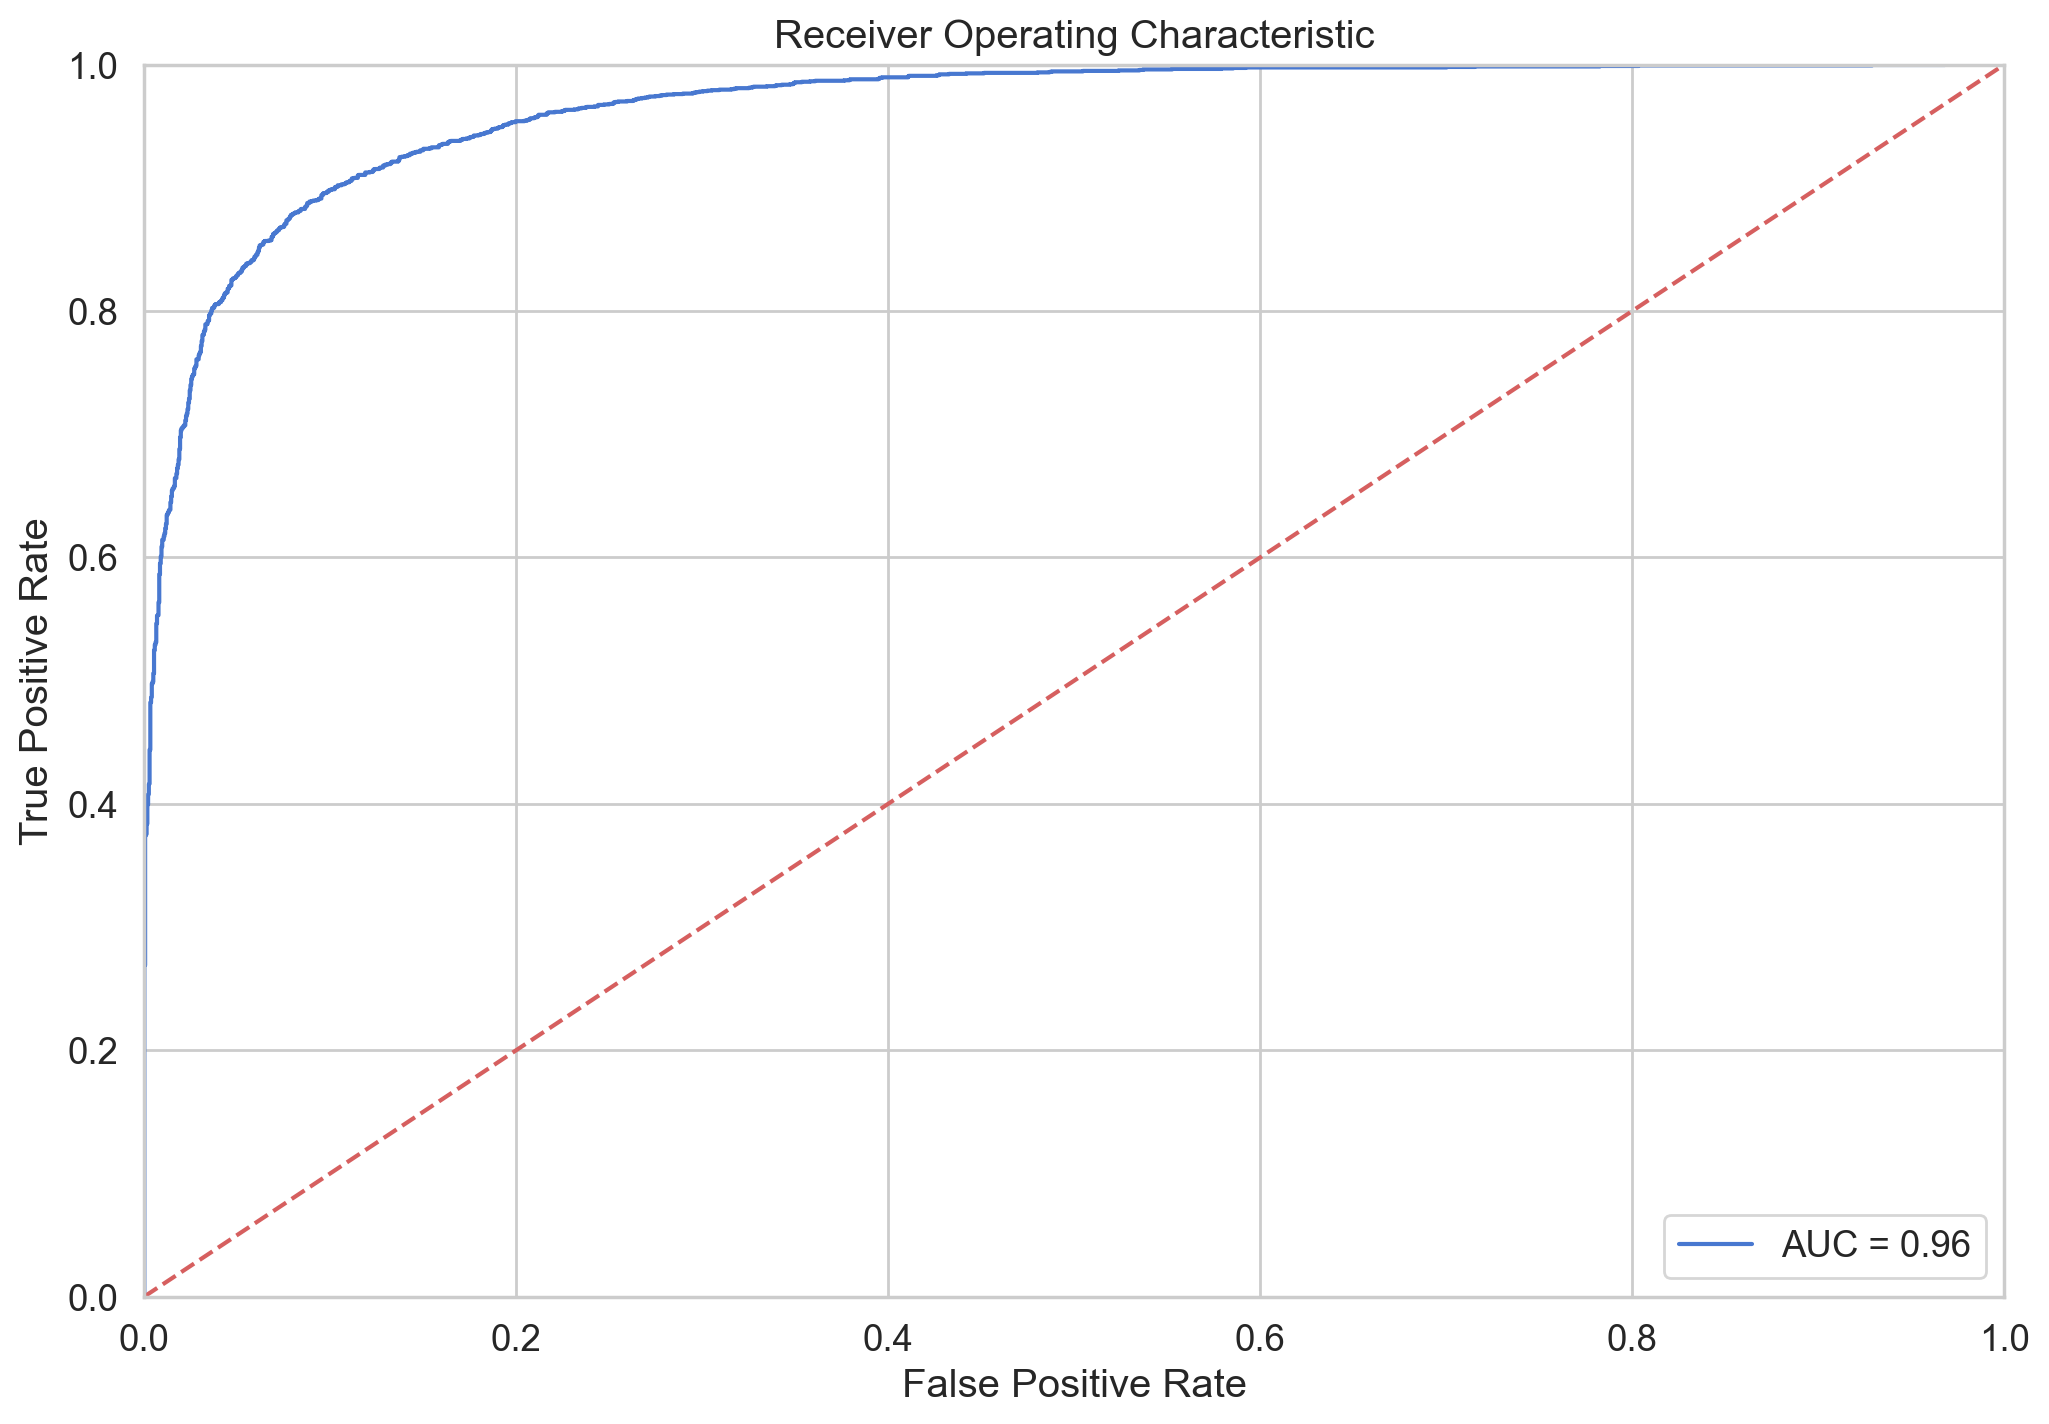

In [28]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

Подготовим данные для теста

In [12]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

Tokenizing data...


E:\projects\innopolis_ai\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Рассмотрим разницу между количеством полученных меток в тесте и в предикте и построим ROC-AUC

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of review predicted non-negative
print("Number of review predicted non-negative: ", preds.sum())
print(y_test.sum())


Number of review predicted non-negative:  2247
2462


NameError: name 'evaluate_roc' is not defined

AUC: 0.9648
Accuracy: 89.44%


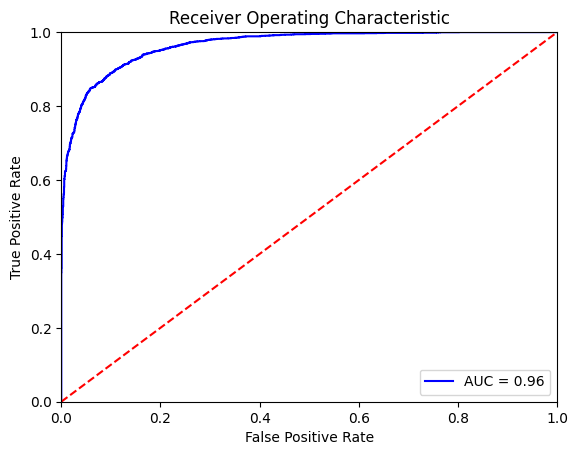

In [27]:
evaluate_roc(probs, y_test)

На тестовых данных тоже получаем неплохую оценку, модель на основе BERT показывает хорошие результаты

Сохраним полученную модель

In [40]:
torch.save(bert_classifier.state_dict(), 'models/bert_classifier.h5')

Пример загрузки модели

In [ ]:
bert_classifier = BertClassifier()
bert_classifier.load_state_dict(torch.load('models/bert_classifier.h5'))